# NB02: Literature Coverage Skew — How Understudied Are Most Genes and Organisms?

Key questions:
1. What fraction of papers/gene-records are captured by the top N organisms?
2. What fraction of literature is captured by the top N genes?
3. Top 50 organisms and genes by literature coverage
4. Why ~1.1M genes and ~1.1M papers — is that a coincidence?
5. SwissProt coverage: how much of it is in PaperBLAST?

In [1]:
from berdl_notebook_utils.setup_spark_session import get_spark_session
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

spark = get_spark_session()
DB = 'kescience_paperblast'
DATA_OUT = Path('../data')
FIG_OUT = Path('../figures')

## 1. Organism Coverage Skew

In [2]:
# Papers per organism (via genepaper joined with gene)
org_papers = spark.sql(f"""
    SELECT g.organism, 
           COUNT(DISTINCT gp.pmId) as n_papers,
           COUNT(*) as n_gene_paper_records,
           COUNT(DISTINCT gp.geneId) as n_genes
    FROM {DB}.genepaper gp
    JOIN {DB}.gene g ON gp.geneId = g.geneId
    WHERE g.organism IS NOT NULL AND g.organism != ''
    GROUP BY g.organism
    ORDER BY n_papers DESC
""").toPandas()

print(f'Organisms with literature: {len(org_papers):,}')
print(f'Total unique papers (sum may double-count): {org_papers["n_papers"].sum():,}')
print(f'Total gene-paper records: {org_papers["n_gene_paper_records"].sum():,}')
print()

# Cumulative coverage
org_papers_sorted = org_papers.sort_values('n_papers', ascending=False).reset_index(drop=True)
org_papers_sorted['cum_papers'] = org_papers_sorted['n_papers'].cumsum()
total_papers = org_papers_sorted['n_papers'].sum()
org_papers_sorted['cum_pct'] = 100 * org_papers_sorted['cum_papers'] / total_papers
org_papers_sorted['rank'] = range(1, len(org_papers_sorted) + 1)

# Key thresholds
for n in [1, 5, 10, 20, 50, 100, 500, 1000]:
    if n <= len(org_papers_sorted):
        pct = org_papers_sorted.iloc[n-1]['cum_pct']
        print(f'Top {n:>5} organisms: {pct:>5.1f}% of all paper-organism records')

Organisms with literature: 20,723
Total unique papers (sum may double-count): 1,300,254
Total gene-paper records: 3,195,890

Top     1 organisms:  46.7% of all paper-organism records
Top     5 organisms:  72.8% of all paper-organism records
Top    10 organisms:  76.8% of all paper-organism records
Top    20 organisms:  80.5% of all paper-organism records
Top    50 organisms:  83.8% of all paper-organism records
Top   100 organisms:  86.3% of all paper-organism records
Top   500 organisms:  92.1% of all paper-organism records
Top  1000 organisms:  94.2% of all paper-organism records


In [3]:
# Top 50 organisms
top50_orgs = org_papers_sorted.head(50)[['rank', 'organism', 'n_papers', 'n_genes', 'n_gene_paper_records', 'cum_pct']].copy()
print('Top 50 Organisms by Paper Count')
print('=' * 120)
print(top50_orgs.to_string(index=False, max_colwidth=70))
top50_orgs.to_csv(DATA_OUT / 'top50_organisms.csv', index=False)

Top 50 Organisms by Paper Count
 rank                                                         organism  n_papers  n_genes  n_gene_paper_records   cum_pct
    1                                                     Homo sapiens    606614    41362               1106791 46.653500
    2                                                     Mus musculus    220537    28187                353129 63.614571
    3                                                Rattus norvegicus     60298    14513                106124 68.251972
    4                                             Arabidopsis thaliana     39964    38231                227169 71.325526
    5                                          Drosophila melanogaster     19573    10436                 38119 72.830847
    6                                         Saccharomyces cerevisiae     13624     5870                 59436 73.878642
    7                                   Saccharomyces cerevisiae S288C     12474     3586                 19352 74

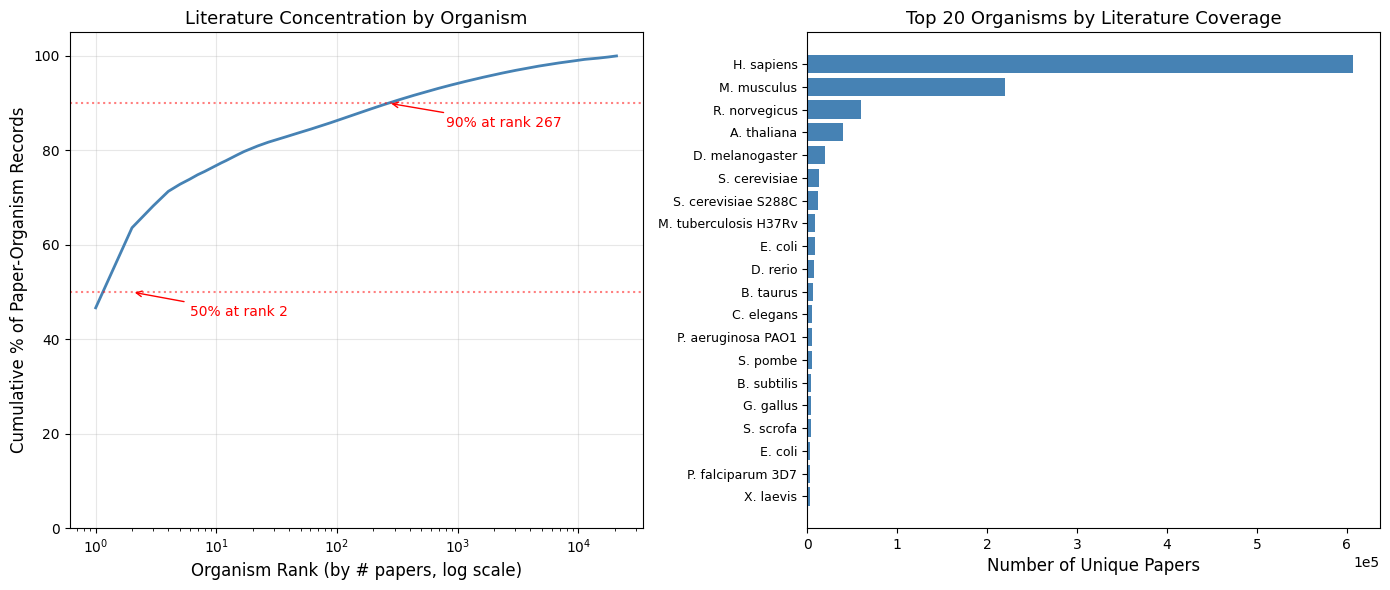

In [4]:
# Figure: Organism cumulative coverage curve
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Cumulative % of papers vs organism rank (log x)
ax = axes[0]
ax.plot(org_papers_sorted['rank'], org_papers_sorted['cum_pct'], color='steelblue', linewidth=2)
ax.set_xscale('log')
ax.set_xlabel('Organism Rank (by # papers, log scale)', fontsize=12)
ax.set_ylabel('Cumulative % of Paper-Organism Records', fontsize=12)
ax.set_title('Literature Concentration by Organism', fontsize=13)
ax.axhline(50, color='red', linestyle=':', alpha=0.5)
ax.axhline(90, color='red', linestyle=':', alpha=0.5)
# Find rank at 50% and 90%
rank_50 = org_papers_sorted[org_papers_sorted['cum_pct'] >= 50].iloc[0]['rank']
rank_90 = org_papers_sorted[org_papers_sorted['cum_pct'] >= 90].iloc[0]['rank']
ax.annotate(f'50% at rank {int(rank_50)}', xy=(rank_50, 50), fontsize=10, color='red',
            xytext=(rank_50*3, 45), arrowprops=dict(arrowstyle='->', color='red'))
ax.annotate(f'90% at rank {int(rank_90)}', xy=(rank_90, 90), fontsize=10, color='red',
            xytext=(rank_90*3, 85), arrowprops=dict(arrowstyle='->', color='red'))
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3)

# Panel B: Top 20 organisms bar chart
ax = axes[1]
top20 = org_papers_sorted.head(20)
# Shorten names
short_names = []
for name in top20['organism']:
    parts = str(name).split()
    if len(parts) >= 2:
        short = f'{parts[0][0]}. {parts[1]}'
        if len(parts) > 2 and parts[2] not in ['(strain', 'str.', 'subsp.']:
            short += f' {parts[2]}'
    else:
        short = str(name)[:25]
    short_names.append(short)

bars = ax.barh(range(len(top20)), top20['n_papers'], color='steelblue', edgecolor='none')
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(short_names, fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Number of Unique Papers', fontsize=12)
ax.set_title('Top 20 Organisms by Literature Coverage', fontsize=13)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

plt.tight_layout()
fig.savefig(FIG_OUT / 'organism_coverage_skew.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Gene Coverage Skew

In [5]:
# Papers per gene
ppg = pd.read_csv(DATA_OUT / 'papers_per_gene.csv')
ppg_sorted = ppg.sort_values('n_papers', ascending=False).reset_index(drop=True)
ppg_sorted['cum_papers'] = ppg_sorted['n_papers'].cumsum()
total_gp = ppg_sorted['n_papers'].sum()
ppg_sorted['cum_pct'] = 100 * ppg_sorted['cum_papers'] / total_gp
ppg_sorted['rank'] = range(1, len(ppg_sorted) + 1)

print(f'Total genes with papers: {len(ppg_sorted):,}')
print(f'Total gene-paper links: {total_gp:,}')
print()

for n in [1, 10, 50, 100, 500, 1000, 5000, 10000, 50000]:
    if n <= len(ppg_sorted):
        pct = ppg_sorted.iloc[n-1]['cum_pct']
        print(f'Top {n:>6} genes ({100*n/len(ppg_sorted):>5.2f}%): {pct:>5.1f}% of all gene-paper links')

Total genes with papers: 840,982
Total gene-paper links: 3,153,664

Top      1 genes ( 0.00%):   0.3% of all gene-paper links
Top     10 genes ( 0.00%):   1.6% of all gene-paper links
Top     50 genes ( 0.01%):   4.6% of all gene-paper links
Top    100 genes ( 0.01%):   6.7% of all gene-paper links
Top    500 genes ( 0.06%):  14.1% of all gene-paper links
Top   1000 genes ( 0.12%):  18.8% of all gene-paper links
Top   5000 genes ( 0.59%):  32.5% of all gene-paper links
Top  10000 genes ( 1.19%):  38.8% of all gene-paper links
Top  50000 genes ( 5.95%):  57.7% of all gene-paper links


In [6]:
# Top 50 genes with descriptions
top50_ids = ppg_sorted.head(50)['geneId'].tolist()
id_str = "','".join(top50_ids)
top50_desc = spark.sql(f"""
    SELECT geneId, organism, desc
    FROM {DB}.gene
    WHERE geneId IN ('{id_str}')
""").toPandas()

top50_genes = ppg_sorted.head(50).merge(top50_desc, on='geneId', how='left')
top50_genes['rank'] = range(1, 51)
print('Top 50 Genes by Paper Count')
print('=' * 140)
print(top50_genes[['rank', 'geneId', 'n_papers', 'organism', 'desc']].to_string(
    index=False, max_colwidth=55))
top50_genes.to_csv(DATA_OUT / 'top50_genes.csv', index=False)

Top 50 Genes by Paper Count
 rank         geneId  n_papers     organism                                                    desc
    1 NP_001119584.1      9988 Homo sapiens                    cellular tumor antigen p53 isoform a
    2    NP_000585.2      6002 Homo sapiens                                   tumor necrosis factor
    3    NP_005219.2      5895 Homo sapiens    epidermal growth factor receptor isoform a precursor
    4 NP_001020537.2      4993 Homo sapiens vascular endothelial growth factor A, long form isof...
    5 NP_001289617.1      4958 Homo sapiens                    apolipoprotein E isoform a precursor
    6    NP_000651.3      4760 Homo sapiens transforming growth factor beta-1 proprotein preprop...
    7    NP_005948.3      3816 Homo sapiens   methylenetetrahydrofolate reductase (NADPH) isoform 2
    8    NP_001521.1      3531 Homo sapiens              hypoxia-inducible factor 1-alpha isoform 1
    9    NP_000563.1      3322 Homo sapiens                      interle

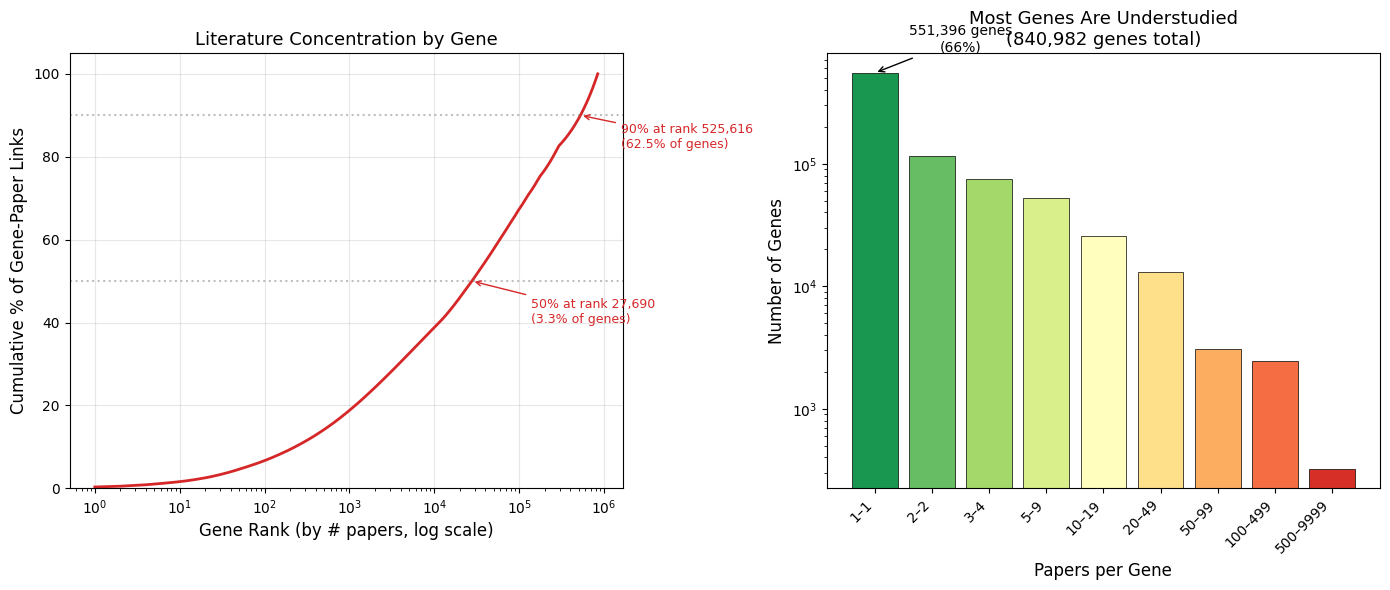

In [7]:
# Figure: Gene coverage skew — Lorenz-style curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Cumulative gene-paper links vs gene rank
ax = axes[0]
ax.plot(ppg_sorted['rank'], ppg_sorted['cum_pct'], color='#d62728', linewidth=2)
ax.set_xscale('log')
ax.set_xlabel('Gene Rank (by # papers, log scale)', fontsize=12)
ax.set_ylabel('Cumulative % of Gene-Paper Links', fontsize=12)
ax.set_title('Literature Concentration by Gene', fontsize=13)
ax.axhline(50, color='gray', linestyle=':', alpha=0.5)
ax.axhline(90, color='gray', linestyle=':', alpha=0.5)
rank_50g = ppg_sorted[ppg_sorted['cum_pct'] >= 50].iloc[0]['rank']
rank_90g = ppg_sorted[ppg_sorted['cum_pct'] >= 90].iloc[0]['rank']
ax.annotate(f'50% at rank {int(rank_50g):,}\n({100*rank_50g/len(ppg_sorted):.1f}% of genes)', 
            xy=(rank_50g, 50), fontsize=9, color='#d62728',
            xytext=(rank_50g*5, 40), arrowprops=dict(arrowstyle='->', color='#d62728'))
ax.annotate(f'90% at rank {int(rank_90g):,}\n({100*rank_90g/len(ppg_sorted):.1f}% of genes)', 
            xy=(rank_90g, 90), fontsize=9, color='#d62728',
            xytext=(rank_90g*3, 82), arrowprops=dict(arrowstyle='->', color='#d62728'))
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3)

# Panel B: Papers-per-gene distribution (zoomed in)
ax = axes[1]
bins = [1, 2, 3, 5, 10, 20, 50, 100, 500, 10000]
counts = []
labels = []
for i in range(len(bins)-1):
    c = ((ppg_sorted['n_papers'] >= bins[i]) & (ppg_sorted['n_papers'] < bins[i+1])).sum()
    counts.append(c)
    labels.append(f'{bins[i]}–{bins[i+1]-1}')

colors = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(counts)))
bars = ax.bar(range(len(counts)), counts, color=colors, edgecolor='black', linewidth=0.5)
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax.set_xlabel('Papers per Gene', fontsize=12)
ax.set_ylabel('Number of Genes', fontsize=12)
ax.set_title(f'Most Genes Are Understudied\n({len(ppg_sorted):,} genes total)', fontsize=13)
ax.set_yscale('log')

# Annotate the 1-paper bar
one_paper = counts[0]
ax.annotate(f'{one_paper:,} genes\n({100*one_paper/len(ppg_sorted):.0f}%)', 
            xy=(0, one_paper), fontsize=10, ha='center',
            xytext=(1.5, one_paper*1.5), arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
fig.savefig(FIG_OUT / 'gene_coverage_skew.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. The 1.1M / 1.1M Coincidence — Genes vs Papers

In [8]:
# How many unique papers are there really?
unique_papers = spark.sql(f"""
    SELECT COUNT(DISTINCT pmId) as n_unique_pmid
    FROM {DB}.genepaper
    WHERE pmId IS NOT NULL
""").collect()[0].n_unique_pmid

unique_genes_in_gp = spark.sql(f"""
    SELECT COUNT(DISTINCT geneId) as n
    FROM {DB}.genepaper
""").collect()[0].n

total_gene_table = spark.sql(f'SELECT COUNT(*) as n FROM {DB}.gene').collect()[0].n

print('Gene vs Paper counts:')
print(f'  Unique genes in gene table:     {total_gene_table:>10,}')
print(f'  Unique genes in genepaper:       {unique_genes_in_gp:>10,}')
print(f'  Unique papers (pmId) in genepaper: {unique_papers:>10,}')
print(f'  Total gene-paper records:        {3195890:>10,}')
print(f'  Records / gene:                  {3195890/unique_genes_in_gp:>10.1f}')
print(f'  Records / paper:                 {3195890/unique_papers:>10.1f}')
print()
print(f'So: ~{unique_genes_in_gp/1000:.0f}K genes are linked to ~{unique_papers/1000:.0f}K papers')
print(f'via {3195890/1e6:.1f}M many-to-many associations.')
print(f'The similar counts are somewhat coincidental — each gene averages')
print(f'{3195890/unique_genes_in_gp:.1f} papers and each paper mentions {3195890/unique_papers:.1f} genes.')
print()

# How many genes in gene table have NO papers?
genes_no_papers = total_gene_table - unique_genes_in_gp
print(f'Genes in gene table with NO genepaper link: {genes_no_papers:,} ({100*genes_no_papers/total_gene_table:.1f}%)')
print('(These may only have curated or GeneRIF annotations)')

Gene vs Paper counts:
  Unique genes in gene table:      1,135,366
  Unique genes in genepaper:          844,579
  Unique papers (pmId) in genepaper:  1,106,066
  Total gene-paper records:         3,195,890
  Records / gene:                         3.8
  Records / paper:                        2.9

So: ~845K genes are linked to ~1106K papers
via 3.2M many-to-many associations.
The similar counts are somewhat coincidental — each gene averages
3.8 papers and each paper mentions 2.9 genes.

Genes in gene table with NO genepaper link: 290,787 (25.6%)
(These may only have curated or GeneRIF annotations)


In [9]:
# Papers per paper — how many genes does each paper mention?
genes_per_paper = spark.sql(f"""
    SELECT pmId, COUNT(DISTINCT geneId) as n_genes
    FROM {DB}.genepaper
    WHERE pmId IS NOT NULL
    GROUP BY pmId
""").toPandas()

print('Genes mentioned per paper:')
print(genes_per_paper['n_genes'].describe().to_string())
print()

# Distribution
for threshold in [1, 2, 5, 10, 50, 100]:
    count = (genes_per_paper['n_genes'] >= threshold).sum()
    print(f'Papers mentioning ≥{threshold:>3} genes: {count:>8,} ({100*count/len(genes_per_paper):.1f}%)')

Genes mentioned per paper:
count    1.106066e+06
mean     2.851244e+00
std      1.250113e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.150000e+03

Papers mentioning ≥  1 genes: 1,106,066 (100.0%)
Papers mentioning ≥  2 genes:  403,431 (36.5%)
Papers mentioning ≥  5 genes:   76,152 (6.9%)
Papers mentioning ≥ 10 genes:   40,242 (3.6%)
Papers mentioning ≥ 50 genes:    7,343 (0.7%)
Papers mentioning ≥100 genes:    2,284 (0.2%)


## 4. SwissProt Coverage

In [10]:
# SwissProt in curatedgene (the curated annotations table)
sp_curated = spark.sql(f"""
    SELECT COUNT(*) as n_entries, COUNT(DISTINCT protId) as n_proteins
    FROM {DB}.curatedgene
    WHERE db = 'SwissProt'
""").toPandas()
print(f'SwissProt entries in curatedgene: {sp_curated["n_entries"].values[0]:,}')
print(f'SwissProt unique proteins:        {sp_curated["n_proteins"].values[0]:,}')

# SwissProt in curatedpaper (the curated references table)
sp_papers = spark.sql(f"""
    SELECT COUNT(*) as n_links, COUNT(DISTINCT protId) as n_proteins, 
           COUNT(DISTINCT pmId) as n_papers
    FROM {DB}.curatedpaper
    WHERE db = 'SwissProt'
""").toPandas()
print(f'\nSwissProt curated paper links:    {sp_papers["n_links"].values[0]:,}')
print(f'SwissProt proteins with papers:   {sp_papers["n_proteins"].values[0]:,}')
print(f'SwissProt unique papers:          {sp_papers["n_papers"].values[0]:,}')

# SwissProt in seqtoduplicate (cross-references)
sp_xref = spark.sql(f"""
    SELECT COUNT(*) as cnt
    FROM {DB}.seqtoduplicate
    WHERE duplicate_id LIKE 'SwissProt::%'
""").collect()[0].cnt
print(f'\nSwissProt cross-references in seqtoduplicate: {sp_xref:,}')

print()
print('Interpretation:')
print('PaperBLAST includes 110K SwissProt entries in its curated data (curatedgene).')
print('Full SwissProt has ~570K reviewed entries (as of 2024). So PaperBLAST includes')
print(f'~{100*110171/570000:.0f}% of SwissProt. The subset likely reflects proteins that')
print('PaperBLAST could match to PMC full-text articles, since PaperBLAST only')
print('processes proteins it can find mentioned in open-access literature.')

SwissProt entries in curatedgene: 110,171
SwissProt unique proteins:        110,171



SwissProt curated paper links:    341,265
SwissProt proteins with papers:   108,892
SwissProt unique papers:          181,916



SwissProt cross-references in seqtoduplicate: 77,809

Interpretation:
PaperBLAST includes 110K SwissProt entries in its curated data (curatedgene).
Full SwissProt has ~570K reviewed entries (as of 2024). So PaperBLAST includes
~19% of SwissProt. The subset likely reflects proteins that
PaperBLAST could match to PMC full-text articles, since PaperBLAST only
processes proteins it can find mentioned in open-access literature.


In [11]:
# All curated databases breakdown
all_curated = spark.sql(f"""
    SELECT cg.db, 
           COUNT(DISTINCT cg.protId) as n_proteins,
           COUNT(DISTINCT cp.pmId) as n_papers
    FROM {DB}.curatedgene cg
    LEFT JOIN {DB}.curatedpaper cp ON cg.db = cp.db AND cg.protId = cp.protId
    GROUP BY cg.db
    ORDER BY n_proteins DESC
""").toPandas()
all_curated['papers_per_protein'] = (all_curated['n_papers'] / all_curated['n_proteins']).round(1)

print('Curated databases — proteins and paper coverage:')
print(all_curated.to_string(index=False))

Curated databases — proteins and paper coverage:
        db  n_proteins  n_papers  papers_per_protein
 SwissProt      110171    181916                 1.7
    biolip       42571     23768                 0.6
    BRENDA       33012     43760                 1.3
   metacyc       12700     46176                 3.6
    REBASE       12388         0                 0.0
       ENA        9251      5717                 0.6
      CAZy        8878         0                 0.0
      TCDB        8509     10810                 1.3
CharProtDB        8021     10263                 1.3
    ecocyc        4198     22304                 5.3
regprecise        3159         0                 0.0
    reanno        1885         0                 0.0
  prodoric         353       640                 1.8


## 5. The "Long Tail" — Combined Visualization

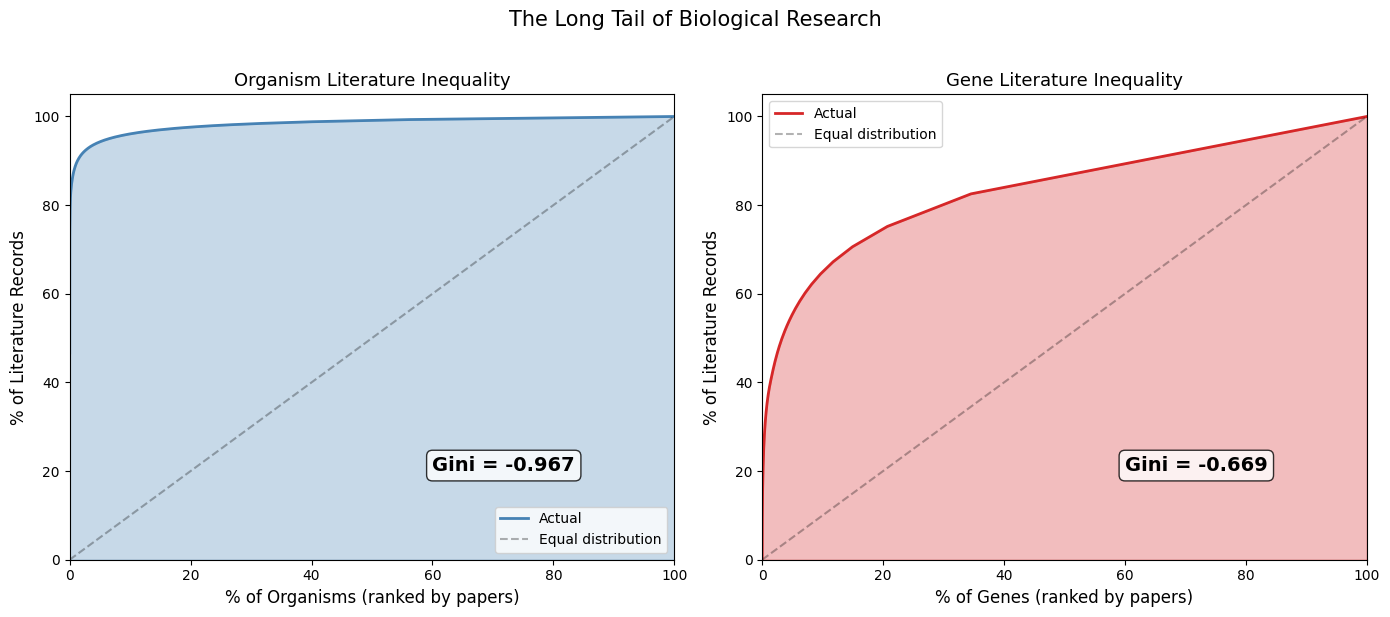

Organism Gini coefficient: -0.967
Gene Gini coefficient: -0.669
(1.0 = perfect inequality, 0.0 = perfect equality)


In [12]:
# Combined figure: organism and gene Lorenz curves side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Organism Lorenz curve (proportion of organisms vs proportion of literature)
ax = axes[0]
n_orgs = len(org_papers_sorted)
x_org = np.arange(1, n_orgs + 1) / n_orgs * 100  # percentage of organisms
y_org = org_papers_sorted['cum_pct'].values
ax.fill_between(x_org, y_org, alpha=0.3, color='steelblue')
ax.plot(x_org, y_org, color='steelblue', linewidth=2, label='Actual')
ax.plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Equal distribution')
ax.set_xlabel('% of Organisms (ranked by papers)', fontsize=12)
ax.set_ylabel('% of Literature Records', fontsize=12)
ax.set_title('Organism Literature Inequality', fontsize=13)

# Calculate Gini coefficient
papers_arr = org_papers_sorted['n_papers'].values
n = len(papers_arr)
gini_org = (2 * np.sum((np.arange(1, n+1)) * papers_arr) / (n * np.sum(papers_arr))) - (n + 1) / n
ax.text(60, 20, f'Gini = {gini_org:.3f}', fontsize=14, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.legend(fontsize=10)
ax.set_xlim(0, 100)
ax.set_ylim(0, 105)

# Panel B: Gene Lorenz curve
ax = axes[1]
n_genes = len(ppg_sorted)
x_gene = np.arange(1, n_genes + 1) / n_genes * 100
y_gene = ppg_sorted['cum_pct'].values
ax.fill_between(x_gene, y_gene, alpha=0.3, color='#d62728')
ax.plot(x_gene, y_gene, color='#d62728', linewidth=2, label='Actual')
ax.plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Equal distribution')
ax.set_xlabel('% of Genes (ranked by papers)', fontsize=12)
ax.set_ylabel('% of Literature Records', fontsize=12)
ax.set_title('Gene Literature Inequality', fontsize=13)

papers_arr_g = ppg_sorted['n_papers'].values
n_g = len(papers_arr_g)
gini_gene = (2 * np.sum((np.arange(1, n_g+1)) * papers_arr_g) / (n_g * np.sum(papers_arr_g))) - (n_g + 1) / n_g
ax.text(60, 20, f'Gini = {gini_gene:.3f}', fontsize=14, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.legend(fontsize=10)
ax.set_xlim(0, 100)
ax.set_ylim(0, 105)

plt.suptitle('The Long Tail of Biological Research', fontsize=15, y=1.02)
plt.tight_layout()
fig.savefig(FIG_OUT / 'lorenz_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Organism Gini coefficient: {gini_org:.3f}')
print(f'Gene Gini coefficient: {gini_gene:.3f}')
print('(1.0 = perfect inequality, 0.0 = perfect equality)')

## 6. Bacterial Focus — Top Microbes

In [13]:
# Filter to bacteria only (rough heuristic)
def is_bacterium(org):
    org_lower = str(org).lower()
    # Exclude known eukaryotes, viruses, archaea
    euk = ['homo ', 'mus ', 'rattus', 'drosophila', 'caenorhabditis', 'saccharomyces',
           'arabidopsis', 'danio', 'xenopus', 'gallus', 'bos ', 'sus ', 'zea ',
           'oryza', 'nicotiana', 'aspergillus', 'candida', 'plasmodium',
           'schizosaccharomyces', 'neurospora', 'pichia', 'dictyostelium',
           'canis ', 'felis', 'equus', 'ovis ', 'macaca', 'pan ', 'pongo',
           'oryctolagus', 'cricetulus', 'trypanosoma', 'leishmania', 'toxoplasma',
           'chlamydomonas', 'physcomitrella', 'selaginella', 'solanum', 'gossypium']
    if any(k in org_lower for k in euk):
        return False
    virus = ['virus', 'phage', 'viridae', 'bacteriophage', 'sars-cov', 'hiv-',
             'influenza', 'herpes', 'hepatitis', 'poxvir', 'retrovir']
    if any(k in org_lower for k in virus):
        return False
    arch = ['methan', 'sulfolobus', 'halobacterium', 'haloferax', 'pyrococcus',
            'thermococcus', 'archaeoglobus', 'nanoarchaeum', 'nitrosopumilus',
            'haloquadratum']
    if any(k in org_lower for k in arch):
        return False
    return True

bacteria = org_papers_sorted[org_papers_sorted['organism'].apply(is_bacterium)].copy()
bacteria = bacteria.reset_index(drop=True)
bacteria['cum_papers_bact'] = bacteria['n_papers'].cumsum()
bact_total = bacteria['n_papers'].sum()
bacteria['cum_pct_bact'] = 100 * bacteria['cum_papers_bact'] / bact_total

print(f'Bacterial organisms: {len(bacteria):,}')
print(f'Total bacterial paper-organism records: {bact_total:,}')
print()

for n in [1, 5, 10, 20, 50, 100]:
    if n <= len(bacteria):
        pct = bacteria.iloc[n-1]['cum_pct_bact']
        print(f'Top {n:>3} bacteria: {pct:>5.1f}% of bacterial literature')

print()
print('Top 20 bacteria:')
print(bacteria.head(20)[['organism', 'n_papers', 'n_genes', 'cum_pct_bact']].to_string(index=False, max_colwidth=60))

Bacterial organisms: 15,312
Total bacterial paper-organism records: 210,287

Top   1 bacteria:   4.3% of bacterial literature
Top   5 bacteria:  15.3% of bacterial literature
Top  10 bacteria:  19.8% of bacterial literature
Top  20 bacteria:  25.3% of bacterial literature
Top  50 bacteria:  35.0% of bacterial literature
Top 100 bacteria:  44.3% of bacterial literature

Top 20 bacteria:
                                                    organism  n_papers  n_genes  cum_pct_bact
                            Mycobacterium tuberculosis H37Rv      9079     4960      4.317433
                   Escherichia coli str. K-12 substr. MG1655      8860     5842      8.530722
                                 Pseudomonas aeruginosa PAO1      5928     5969     11.349727
                  Bacillus subtilis subsp. subtilis str. 168      4805     3745     13.634699
                               Escherichia coli (strain K12)      3435     2746     15.268181
                                  Salmonella ty

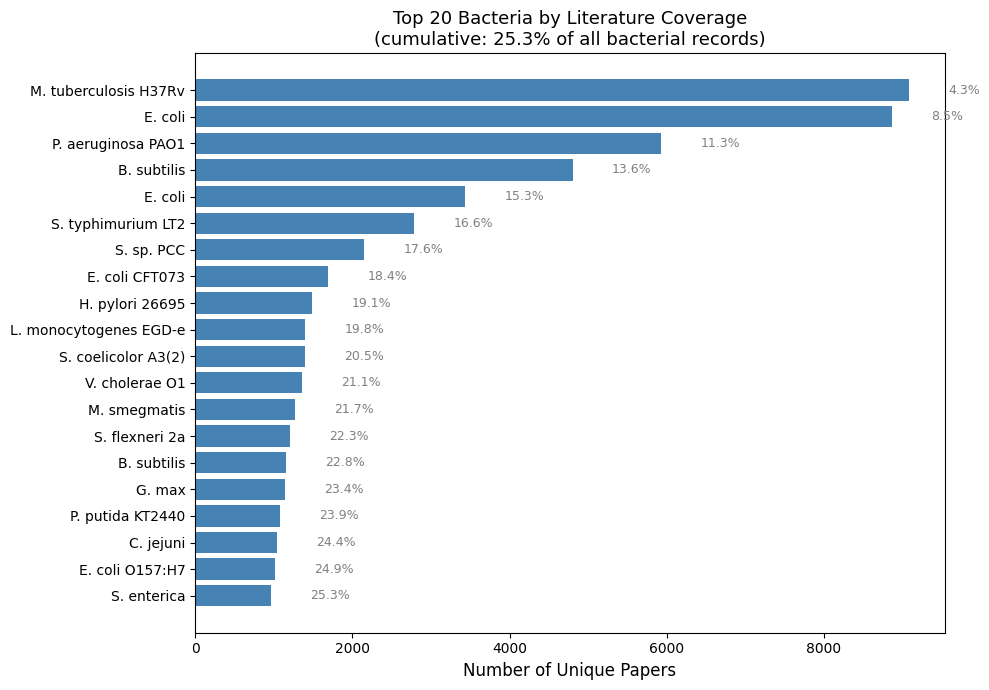

In [14]:
# Figure: Top 20 bacteria
fig, ax = plt.subplots(figsize=(10, 7))
top20_bact = bacteria.head(20)
short_names_b = []
for name in top20_bact['organism']:
    parts = str(name).split()
    if len(parts) >= 2:
        short = f'{parts[0][0]}. {parts[1]}'
        if len(parts) > 2 and parts[2] not in ['(strain', 'str.', 'subsp.', 'sp.']:
            short += f' {parts[2]}'
    else:
        short = str(name)[:30]
    short_names_b.append(short)

bars = ax.barh(range(len(top20_bact)), top20_bact['n_papers'], 
               color='steelblue', edgecolor='none')
ax.set_yticks(range(len(top20_bact)))
ax.set_yticklabels(short_names_b, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Number of Unique Papers', fontsize=12)
ax.set_title(f'Top 20 Bacteria by Literature Coverage\n(cumulative: {top20_bact.iloc[-1]["cum_pct_bact"]:.1f}% of all bacterial records)', fontsize=13)

# Add cumulative % labels
for i, (_, row) in enumerate(top20_bact.iterrows()):
    ax.text(row['n_papers'] + 500, i, f'{row["cum_pct_bact"]:.1f}%', 
            va='center', fontsize=9, color='gray')

plt.tight_layout()
fig.savefig(FIG_OUT / 'top20_bacteria.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

Key takeaways:
1. **Literature is extremely concentrated** — a small fraction of organisms and genes account for the bulk of publications
2. **65.6% of genes have exactly 1 paper** — the long tail is massive
3. **The top 20 most-cited genes are all human** — p53, TNF, EGFR dominate
4. **SwissProt covers ~110K of ~570K entries** — PaperBLAST includes proteins it can match to PMC text
5. **The 1.1M/1.1M coincidence** is because most genes have few papers and most papers mention few genes